# HW 2

## Problem 1 15 points

Consider proof-of-work via finding birthday collisions(see http://www.hashcash.org/papers/momentum.pdf). 

1.Write probability of a matchand probability of matching fixed value for a set of N unique values as a function of the observation number  5 points

Напишите вероятность совпадения и вероятность сопоставления фиксированного значения для набора из N уникальных значений в зависимости от номера наблюдения

As it's exactly well known problem in probability theory https://en.wikipedia.org/wiki/Birthday_problem 
$$
p(n) = 1 - \frac{N!}{N^n(N-n)!},\  n \leq N \\ 
p(n) = 1, \ n > N
$$
And this is the answer on the first task
$$q(n) = 1 - \Big(\frac{N-1}{N}\Big)^n $$
And this is the answer on the second task

In [2]:
import decimal

def p(N, n):
    decimal.getcontext().prec = 20  
    if n <= N:
        r = 1
        for z in range(N-n+1, N+1):
            r *= z
        return float(1 - r/(decimal.Decimal(N) ** decimal.Decimal(n)))
    else:
        return 1.0

def q(N, n):
    return 1 - pow((N-1)/N, n)

In [2]:
p(365,23)

0.5072972343239854

[]

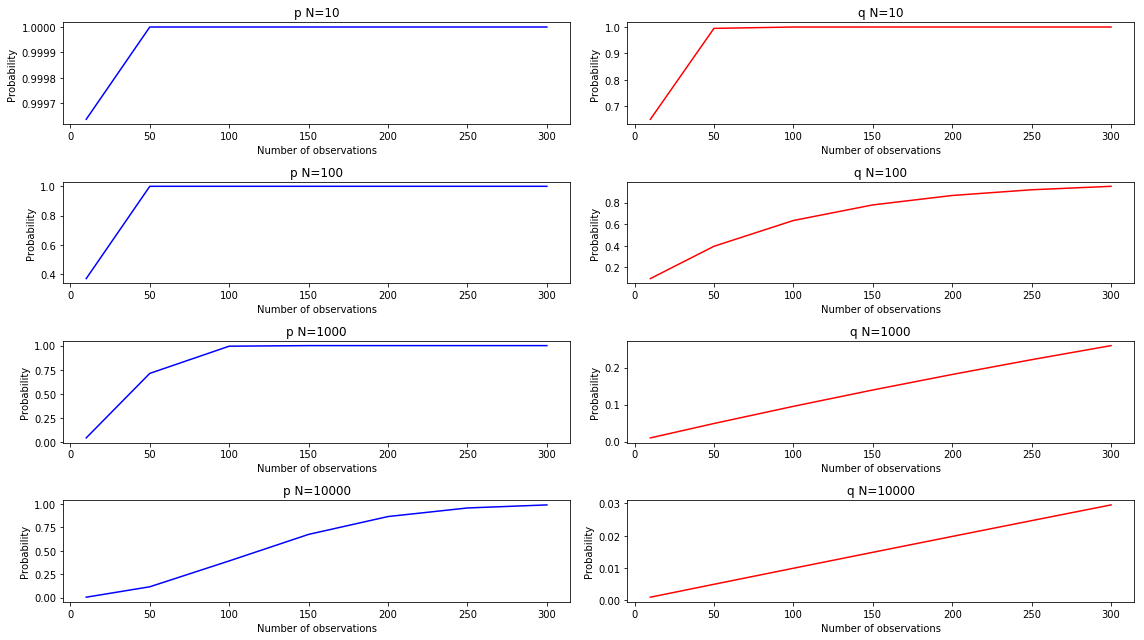

In [4]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,9))

Ns = [10, 100, 1000, 10000]
ns = [10, 50, 100, 150, 200, 250, 300]

number_of_columns = 2
number_of_rows = len(Ns)
plot_idx = 1

for N in Ns:
    ps = []
    qs = []
    for n in ns:
        ps.append(p(N,n))
        qs.append(q(N,n))
    
    plt.subplot(number_of_rows, number_of_columns, plot_idx)
    plt.plot(ns, ps, 'b')
    plot_idx += 1
    plt.title("p N={}".format(N))
    plt.xlabel('Number of observations')
    plt.ylabel('Probability')
    plt.tight_layout()
        
    
    plt.subplot(number_of_rows, number_of_columns, plot_idx)
    plot_idx += 1
    plt.title("q N={}".format(N))
    plt.plot(ns, qs, 'r')
    plt.xlabel('Number of observations')
    plt.ylabel('Probability')
    plt.tight_layout()

    

plt.plot()
        

It means that computationally it's not easy to find match (with some specified number) if the number of possible values is big enough.

In [24]:
N = 10000
i = 1
x = 0
while q(N, i)!=1.0:
    x += q(N, i)*i
    i += 1
    
print("Mean number of iterations for q and N=10000: {}".format(int(x)))

Mean number of iterations for q and N=10000: 69942956340


So even if you'll use massive parallelism it would not be so effective as using memory. When we use memory, we transform the problem to the p distribution, hence it's easier to find the answer, but more memory is required.

3.Propose the proof-of-work function with difficulty and CPU/memory parameters. 5 points

I'll propose to use dict(int32:int32) (hash table) to store birthdays.

Initial state: dict={}. 

During the  execution we add new elements to dict, as if we faced number 5, we get

dict == {5: 1}, then number 6 ==> dict == {5: 1, 6: 1}. If we face the same number (which already been in dict) we stop the iteration process (proof of work process).

Hence we are adding elements to dictionary every iteration we can calculate the mean number of iterations and mean value for memory like this

$$E(iter) = \sum_{i=1}^{N+1} i\cdot z(N,i)$$

Where $z$ is the distribution which corresponds to "finding the pair with the same birthday exactly on this step"

$$E(memory_{bytes}) = E(iter) \cdot 2 \cdot 4 + C$$

Where $C$ is a constant number which is connected with hash table storage overhead.

So, what do we have now
1. If somebody tries to reduce memory consumption, then the task transform to $q$ distribution and thus calculations will take too much time
2. Using the $p$ distribution requires the memory which is acceptable for one computer, but not acceptable for multiple computers, connected via internet, because synchronization of even few mbytes will cut off advantages of parallel computation (due to network lags)
3. Using this hash function the system could be a bit more confidential, this is what we wanted to achieve

## Problem 2 (20 points)

Elliptic curves play an important role in modern cryptography. In this problem you will become familiar with basic operations over them

1.Implement python function that makes an addition operation of two elliptic curve points. The function must take a coefficient of the elliptic curve in Weierstrass Form ($y^2=x^3-px-q$), the base of the finite field over which we consider our curve and coordinates of points. Please note that there are four possible cases depending on points mutual agreement (here we also mean adding of two similar points) 4 points

2.Implement python function that makes a multiplication of elliptic curve point by a natural number. The function must take a coefficient of the elliptic curve in Weierstrass Form ($y^2=x^3-px-q$), the base of the finite field over which we consider our curve, coordinate of point and integer number. Please note that $aA$ is equal to $A+....+A$ a times 4 points

3.Implement python function that produces the common secret key in elliptic curve version of the Diffie-Hellman protocol. The function must take a coefficient of the elliptic curve in Weierstrass Form ($y^2=x^3-px-q$), the base of the finite field over which we consider our curve, generator point of the group of points in this curve and Bob's and Alices' secret keys (natural numbers). Please note that in this problem we change $g^amod p$ operation by $aG$, there $a$ is secret key and $G$ is generator point. 4 points

4.For a given point of elliptic curve in Wierstrass form ($y^2=x^3-px-q$) write a python function that make a list of all point in group generated by this point. 4 points

In [83]:
class Elliptic(object):
    """
    eliptic curve operations
    getting y^2 = x^3 - px - q 
    storing y^2 = x^3 + ax + b
    """
    O_point = (0, 0)
    
    def __init__(self, p, q, base, *args, **kwargs):
        """
        p,q are corresponidng coefficiens of eliptic curve in Weierstrass Form
        base - base of finite field which we consider our curve
        """
        assert isinstance(p, int), "p coefficent must be int"
        assert isinstance(q, int), "q coefficent must be int"
        assert (base != 2) and (base != 3), "we do not consider base 2 and 3"
        assert base >= 0, "char must be greater or equal than zero"
        self.a = -p
        self.b = -q
        self.base = base
        
        if self.base:
            assert -16*(4*pow(self.a,3) + 27*self.b**2) % self.base != 0, "not correct elliptic curve"
        else:
            assert -16*(4*pow(self.a,3) + 27*self.b**2) != 0, "not correct elliptic curve"
    
    def _inv (self,elem):
        if self.base:
            return pow(elem, self.base - 2, self.base)
        else:
            return 1/(x1-x2)
    
    def point_addition(self, x1, y1, x2, y2):
        x,y = self.O_point
        if x1 != x2:
            s = (y1-y2)*self._inv(x1-x2)
            x = s**2 - x1 - x2
            y = -y1 + s*(x1 - x)
        else:
            if y1 == -y2:
                pass
            if y1 == y2:
                if y2 != 0:
                    s = (3*x1**2 + self.a)*self._inv(2*y1)
                    x = s**2 - 2*x1
                    y = -y1 + s * (x1 - x)
        
        if self.base:
            return (x % self.base, y % self.base)
        else:
            return (x,y)
        
    def multiply_by_natural(self, x, y, a):
        assert a > 0, "a must be natural number"
        assert isinstance(a, int), "a must be natural number"
        
        init_x, init_y = x,y
        for i in range(a-1):
            x, y = self.point_addition(x,y,init_x,init_y)
            
        return x,y
            
    def generate_secret_key(self, Gx, Gy, alice_secret, bob_secret):
        assert alice_secret > 0, "alice_secret must be natural number"
        assert isinstance(alice_secret, int), "alice_secret must be natural number"
        assert bob_secret > 0, "bob_secret must be natural number"
        assert isinstance(bob_secret, int), "bob_secret must be natural number"
        
        Qbx, Qby = self.multiply_by_natural(Gx,Gy, bob_secret)
        Qax, Qay = self.multiply_by_natural(Gx,Gy, alice_secret)
        
        secret = self.multiply_by_natural(Qbx, Qby, alice_secret)[0]
        assert secret == self.multiply_by_natural(Qax, Qay, bob_secret)[0], "Something went wrong"
        
        return secret
    
    def generate_points(self, x,y):
        res = set()
        res.add((x,y))
        init_x, init_y = x, y
        if self.base:
            current = (init_x, init_y)
            while current != (0, 0):
                current = self.point_addition(current[0], current[1], init_x, init_y)
                res.add(current)
            return list(res)
        else:
            print("Real number, returning [0]")
            return [0]
        
        

5.Test you functions over elliptic curve $y^2=x^3-3x-6$ over $\mathbf{F}_{17}$ with generator point $G=(15;3)$, Bob's secret key is 3 and Alice secret key is 2. In other words give the full list of points of this elliptic curve and provide a common secret key in the Diffie-Hellman protocol. 4 points

In [84]:
curve = Elliptic(3,6,17)
print("Secret key {}".format(curve.generate_secret_key(15, 3, 2, 3)))
print("Points list {}".format(curve.generate_points(15,3)))

Secret key 15
Points list [(9, 13), (0, 0), (2, 9), (15, 3), (2, 8), (9, 4), (15, 14)]


## Problem 3 15 points

Consider the following employee relation, and the way salary should be partitioned.



<img src="pic1.png">

Consider the following query:

SELECT did, SUM(salary)

FROM EMPLOYEE

GROUP BY did.


Formulate in relational algebra form (5 points)

π did, summary

γ did; SUM(salary)→summary

EMPLOYEE

Formulate the SQL query to show all employee receiving salary in given range (5 points)

SELECT 

    eid, name
    
FROM EMPLOYEE

WHERE 

    salary BETWEEN min AND max

Formulate the SQL query to show city with maximal salary (5 points)

SELECT

    city, MAX(salary) as msal
    
FROM EMPLOYEE

GROUP BY city

ORDER BY msal DESC

LIMIT 1